# Data Normalization & Standardization

## Imports

In [157]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn import set_config
import seaborn as sns
import matplotlib.pyplot as plt

We'll configure scikit-learn to output in a pandas dataframe to save us having to marry columns to numpy arrays to get DF's again

In [120]:
set_config(transform_output="pandas")

Remove the target variables

In [121]:
initial_df = pd.read_csv('HMEQ_Loss.csv')
no_targets_df = initial_df.drop(['TARGET_BAD_FLAG','TARGET_LOSS_AMT'],axis=1)

Split our dataset into categorical and numerical

In [123]:
# cat only
categorical_columns = no_targets_df.select_dtypes('object')

# num only
numerical_columns = no_targets_df.select_dtypes(exclude='object')


## Impute missing  values

For numerical, we can use the median to fill in the missing values

In [124]:
# for our numerical friends
dropholder = []
for col in numerical_columns:  
    if numerical_columns[col].isna().mean() > 0:
        numerical_columns['imp_'+col] = numerical_columns[col].fillna(numerical_columns[col].median())
        dropholder.append(col)
    else:
        continue

numerical_columns.drop(dropholder,axis=1,inplace=True)

For categorical, we can use the mode (aka the most frequently appearing value)

In [127]:
# for our categorical friends
dropholder = []
for col in categorical_columns:  
    if categorical_columns[col].isna().mean() > 0:
        colmode = categorical_columns[col].value_counts().index[0]
        categorical_columns['imp_'+col] = categorical_columns[col].fillna(colmode)
        dropholder.append(col)
    else:
        continue

categorical_columns.drop(dropholder,axis=1,inplace=True)

## Normalization

Normalization through scikit learn uses MinMaxScaler().

The formula it uses is below:

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_scaled = X_std * (max - min) + min

Step 1 is to instantiate the MinMax Scaler

In [128]:
normalizer = MinMaxScaler()
normalizer.fit(numerical_columns)

MinMaxScaler()

Step 2 is to transform our numerical columns into a new dataframe called normalized

In [129]:
normalized = normalizer.transform(numerical_columns)
normalized = normalized.add_prefix('nor_')
normalized.head()

,nor_LOAN,nor_imp_MORTDUE,nor_imp_VALUE,nor_imp_YOJ,nor_imp_DEROG,nor_imp_DELINQ,nor_imp_CLAGE,nor_imp_NINQ,nor_imp_CLNO,nor_imp_DEBTINC
0,0.000000,0.059869,0.036590,0.256098,0.0,0.000000,0.080777,0.058824,0.126761,0.169112
1,0.002252,0.171050,0.071234,0.170732,0.0,0.133333,0.104289,0.000000,0.197183,0.169112
2,0.004505,0.028773,0.010261,0.097561,0.0,0.000000,0.127942,0.058824,0.140845,0.169112
3,0.004505,0.158385,0.095807,0.170732,0.0,0.000000,0.148486,0.058824,0.281690,0.169112
4,0.006757,0.240856,0.122655,0.073171,0.0,0.000000,0.079893,0.000000,0.197183,0.169112


Step 3 is to validate the normalization with a manually calculated column

In [130]:
normalized['loan_check'] = (numerical_columns['LOAN']-numerical_columns['LOAN'].min())/(numerical_columns['LOAN'].max()-numerical_columns['LOAN'].min())
normalized[['loan_check','nor_LOAN']]


,loan_check,nor_LOAN
0,0.000000,0.000000
1,0.002252,0.002252
2,0.004505,0.004505
3,0.004505,0.004505
4,0.006757,0.006757
...,...,...
5955,0.988739,0.988739
5956,0.989865,0.989865
5957,0.992117,0.992117
5958,0.998874,0.998874


You can see in the chart below the overall shape is maintained during this but the x-axis changes drastically limiting the range of values from 0 to 1.

<AxesSubplot:xlabel='nor_LOAN', ylabel='Count'>

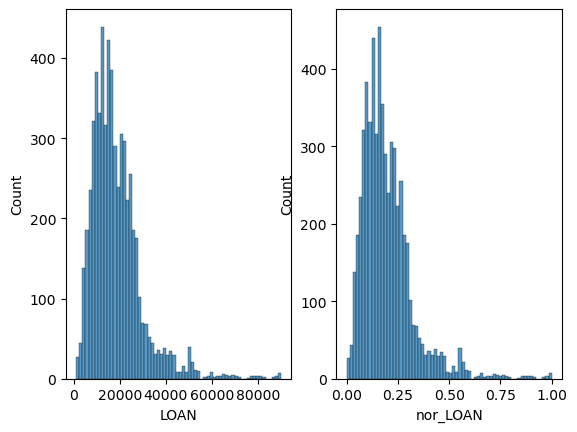

In [168]:
# visualizing the difference between the two
fig, axs = plt.subplots(ncols=2,sharex=False)
sns.histplot(initial_df,x='LOAN',ax=axs[0])
sns.histplot(normalized,x='nor_LOAN',ax=axs[1])

## Standardization

For standardization we use StandardScaler().

The formula is below:

z = (x - u) / s

Step 1 is to instantiate the Standard Scaler

In [131]:
standardizer = StandardScaler()
standardizer.fit(numerical_columns)

StandardScaler()

Step 2 is to transform our numerical columns into a new dataframe called standardized

In [132]:
standardized = standardizer.transform(numerical_columns)
standardized = standardized.add_prefix('std_')
standardized.head()

,std_LOAN,std_imp_MORTDUE,std_imp_VALUE,std_imp_YOJ,std_imp_DEROG,std_imp_DELINQ,std_imp_CLAGE,std_imp_NINQ,std_imp_CLNO,std_imp_DEBTINC
0,-1.562299,-1.107920,-1.099371,0.240237,-0.280976,-0.375943,-1.018026,-0.102879,-1.230878,0.106963
1,-1.544453,-0.069286,-0.582794,-0.241936,-0.280976,1.477341,-0.689350,-0.707574,-0.728389,0.106963
2,-1.526606,-1.398407,-1.491970,-0.655226,-0.280976,-0.375943,-0.358680,-0.102879,-1.130380,0.106963
3,-1.526606,-0.187596,-0.216389,-0.241936,-0.280976,-0.375943,-0.071488,-0.102879,-0.125403,0.106963
4,-1.508759,0.582831,0.183939,-0.792990,-0.280976,-0.375943,-1.030391,-0.707574,-0.728389,0.106963


Step 3 is to validate the standardization with a manually calculated column

Interesting note here is the on the backend the StandardScaler() function leverages NumPy's std(). This uses a default degree of freedom = 0. Pandas' buit in std() function uses degree of freedom 1. I'll leave it as the Pandas one to show the difference in the below cell

In [133]:
standardized['loan_check'] = (numerical_columns['LOAN']-numerical_columns['LOAN'].mean())/numerical_columns['LOAN'].std()
standardized[['loan_check','std_LOAN']]


,loan_check,std_LOAN
0,-1.562168,-1.562299
1,-1.544323,-1.544453
2,-1.526478,-1.526606
3,-1.526478,-1.526606
4,-1.508633,-1.508759
...,...,...
5955,6.271885,6.272411
5956,6.280808,6.281335
5957,6.298653,6.299181
5958,6.352189,6.352722


Here I manually set the degrees of freedom to 0 to match numpy.std() in the column loan_checknumpy

In [134]:
standardized['loan_checknumpy'] = (numerical_columns['LOAN']-numerical_columns['LOAN'].mean())/numerical_columns['LOAN'].std(ddof=0)
standardized[['loan_check','loan_checknumpy','std_LOAN']]

,loan_check,loan_checknumpy,std_LOAN
0,-1.562168,-1.562299,-1.562299
1,-1.544323,-1.544453,-1.544453
2,-1.526478,-1.526606,-1.526606
3,-1.526478,-1.526606,-1.526606
4,-1.508633,-1.508759,-1.508759
...,...,...,...
5955,6.271885,6.272411,6.272411
5956,6.280808,6.281335,6.281335
5957,6.298653,6.299181,6.299181
5958,6.352189,6.352722,6.352722


In the chart below you can see the shape is maintained but the x-axis scale goes from -1 to 6. In a normally distributed data set you'll see the data go from -3 to 3 (3 standard deviations each way from 0).

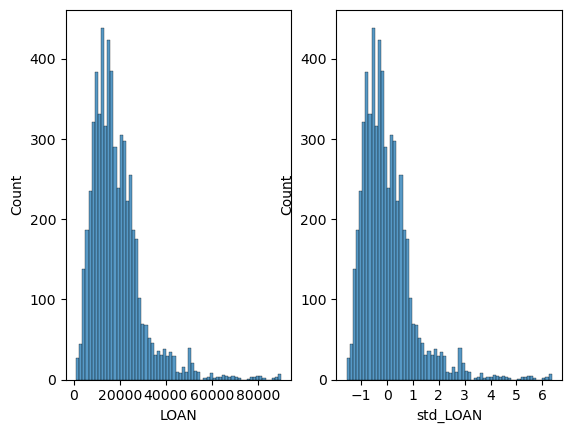

In [169]:
# visualizing the difference between the two
fig2, axs2 = plt.subplots(ncols=2,sharex=False)

sns.histplot(initial_df,x='LOAN',ax=axs2[0])
sns.histplot(standardized,x='std_LOAN',ax=axs2[1])
axs2[1].set_xticks(range(-1,7));

## Categorical One-Hot

Step 1 is to instantiate the onehotencoder just like the above sections

In [135]:
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(categorical_columns)

OneHotEncoder(sparse_output=False)

Step 2 is to transform our columns

In [136]:
encoded = ohe.transform(categorical_columns)
encoded = encoded.add_prefix('ohe_')

Step 3 is to validate

We -1 here to get rid of the nan value

In [149]:
(len(initial_df['JOB'].unique())-1) + (len(initial_df['REASON'].unique())-1)

8

It should be equal to the below

In [150]:
encoded.iloc[0].shape[0]

8

## Recompile

### One big dataset with everything

In [152]:
onebigdf = pd.concat((encoded,normalized,standardized),axis=1)
onebigdf.head()

,ohe_imp_REASON_DebtCon,ohe_imp_REASON_HomeImp,ohe_imp_JOB_Mgr,ohe_imp_JOB_Office,ohe_imp_JOB_Other,ohe_imp_JOB_ProfExe,ohe_imp_JOB_Sales,ohe_imp_JOB_Self,nor_LOAN,nor_imp_MORTDUE,...,std_imp_VALUE,std_imp_YOJ,std_imp_DEROG,std_imp_DELINQ,std_imp_CLAGE,std_imp_NINQ,std_imp_CLNO,std_imp_DEBTINC,loan_check,loan_checknumpy
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.059869,...,-1.099371,0.240237,-0.280976,-0.375943,-1.018026,-0.102879,-1.230878,0.106963,-1.562168,-1.562299
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.002252,0.171050,...,-0.582794,-0.241936,-0.280976,1.477341,-0.689350,-0.707574,-0.728389,0.106963,-1.544323,-1.544453
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.004505,0.028773,...,-1.491970,-0.655226,-0.280976,-0.375943,-0.358680,-0.102879,-1.130380,0.106963,-1.526478,-1.526606
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.004505,0.158385,...,-0.216389,-0.241936,-0.280976,-0.375943,-0.071488,-0.102879,-0.125403,0.106963,-1.526478,-1.526606
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.006757,0.240856,...,0.183939,-0.792990,-0.280976,-0.375943,-1.030391,-0.707574,-0.728389,0.106963,-1.508633,-1.508759


### Normalized + Encoded

In [153]:
normalized_encoded = pd.concat((encoded,normalized),axis=1)
normalized_encoded.head()

,ohe_imp_REASON_DebtCon,ohe_imp_REASON_HomeImp,ohe_imp_JOB_Mgr,ohe_imp_JOB_Office,ohe_imp_JOB_Other,ohe_imp_JOB_ProfExe,ohe_imp_JOB_Sales,ohe_imp_JOB_Self,nor_LOAN,nor_imp_MORTDUE,nor_imp_VALUE,nor_imp_YOJ,nor_imp_DEROG,nor_imp_DELINQ,nor_imp_CLAGE,nor_imp_NINQ,nor_imp_CLNO,nor_imp_DEBTINC,loan_check
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.059869,0.036590,0.256098,0.0,0.000000,0.080777,0.058824,0.126761,0.169112,0.000000
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.002252,0.171050,0.071234,0.170732,0.0,0.133333,0.104289,0.000000,0.197183,0.169112,0.002252
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.004505,0.028773,0.010261,0.097561,0.0,0.000000,0.127942,0.058824,0.140845,0.169112,0.004505
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.004505,0.158385,0.095807,0.170732,0.0,0.000000,0.148486,0.058824,0.281690,0.169112,0.004505
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.006757,0.240856,0.122655,0.073171,0.0,0.000000,0.079893,0.000000,0.197183,0.169112,0.006757


### Standardized + Encoded

In [154]:
standardized_encoded = pd.concat((encoded,standardized),axis=1)
standardized_encoded.head()

,ohe_imp_REASON_DebtCon,ohe_imp_REASON_HomeImp,ohe_imp_JOB_Mgr,ohe_imp_JOB_Office,ohe_imp_JOB_Other,ohe_imp_JOB_ProfExe,ohe_imp_JOB_Sales,ohe_imp_JOB_Self,std_LOAN,std_imp_MORTDUE,std_imp_VALUE,std_imp_YOJ,std_imp_DEROG,std_imp_DELINQ,std_imp_CLAGE,std_imp_NINQ,std_imp_CLNO,std_imp_DEBTINC,loan_check,loan_checknumpy
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.562299,-1.107920,-1.099371,0.240237,-0.280976,-0.375943,-1.018026,-0.102879,-1.230878,0.106963,-1.562168,-1.562299
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.544453,-0.069286,-0.582794,-0.241936,-0.280976,1.477341,-0.689350,-0.707574,-0.728389,0.106963,-1.544323,-1.544453
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.526606,-1.398407,-1.491970,-0.655226,-0.280976,-0.375943,-0.358680,-0.102879,-1.130380,0.106963,-1.526478,-1.526606
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.526606,-0.187596,-0.216389,-0.241936,-0.280976,-0.375943,-0.071488,-0.102879,-0.125403,0.106963,-1.526478,-1.526606
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.508759,0.582831,0.183939,-0.792990,-0.280976,-0.375943,-1.030391,-0.707574,-0.728389,0.106963,-1.508633,-1.508759


## Conclusion

Depending on our end usecase, we need to determine if the Standardized + Encoded dataset is used or the Normalized + Encoded dataset is used. 

Some general guidelines:

- if negative numbers in features are not ok, use normalize
- if you need to center on 0 (mean = 0) use standardize